In [1]:
import os
import torch
import imageio
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imageio.v2 as imageio

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [4]:
# !pip install torchvision

In [ ]:
torch.cuda.is_available()

False

In [6]:
raw_data_train = '/Users/aiden/OneDrive/Desktop/Cybersecurity/CIFAR-10/CIFAR-10-images-master/train'
raw_data_test  = '/Users/aiden/OneDrive/Desktop/Cybersecurity/CIFAR-10/CIFAR-10-images-master/test'

In [7]:
dataset_train = []
labels_train  = []
targets_train = []

In [ ]:
for folder in os.listdir(raw_data_train):
    print(folder)
    for image in os.listdir( os.path.join(raw_data_train, folder)):
        if folder not in labels_train:
            labels_train.append(folder)
        targets_train.append(labels_train.index(folder))
        img_arr = imageio.imread(os.path.join(raw_data_train, folder, image), pilmode="RGB")
        img = torch.from_numpy(img_arr).permute(2, 0, 1).float()
        img /= 255
        dataset_train.append(img)

airplane


In [58]:
len(targets_train)

50000

In [59]:
dataset_train[3].shape

torch.Size([3, 32, 32])

In [65]:
data_train = torch.stack(dataset_train)
targets_train = torch.Tensor(targets_train).type(torch.LongTensor)

torch.save((data_train, targets_train, labels_train), "CIFAR10_data")

In [66]:
data_train.shape

torch.Size([50000, 3, 32, 32])

In [67]:
targets_train.shape

torch.Size([50000])

In [68]:
data_train[4].shape

torch.Size([3, 32, 32])

In [69]:
targets_train[24000:25000]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [70]:
img_tr = data_train[46000]
img_tr

tensor([[[0.8392, 0.8353, 0.7059,  ..., 0.2471, 0.2902, 0.2627],
         [0.8235, 0.8353, 0.7765,  ..., 0.1922, 0.2510, 0.2353],
         [0.8118, 0.7961, 0.7922,  ..., 0.1882, 0.2471, 0.2431],
         ...,
         [0.2078, 0.1647, 0.1255,  ..., 0.4275, 0.4275, 0.4314],
         [0.2392, 0.2471, 0.2235,  ..., 0.4235, 0.4392, 0.4588],
         [0.2314, 0.2510, 0.2275,  ..., 0.4078, 0.4275, 0.4588]],

        [[0.7529, 0.7490, 0.6196,  ..., 0.2588, 0.2980, 0.2706],
         [0.7294, 0.7490, 0.6824,  ..., 0.2078, 0.2588, 0.2510],
         [0.7059, 0.7020, 0.6863,  ..., 0.2196, 0.2627, 0.2706],
         ...,
         [0.2118, 0.1647, 0.1255,  ..., 0.4000, 0.4039, 0.4196],
         [0.2353, 0.2392, 0.2157,  ..., 0.3961, 0.4157, 0.4353],
         [0.2196, 0.2392, 0.2118,  ..., 0.3725, 0.4039, 0.4353]],

        [[0.5569, 0.5569, 0.4353,  ..., 0.1922, 0.2471, 0.2275],
         [0.5412, 0.5569, 0.5098,  ..., 0.1412, 0.2039, 0.1961],
         [0.5294, 0.5216, 0.5176,  ..., 0.1373, 0.1961, 0.

In [71]:
transform = T.ToPILImage()

In [72]:
img = transform(img_tr)

In [73]:
y_train_np = targets_train.numpy()
y_train_np.shape
the_set = np.unique(y_train_np)
the_set

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

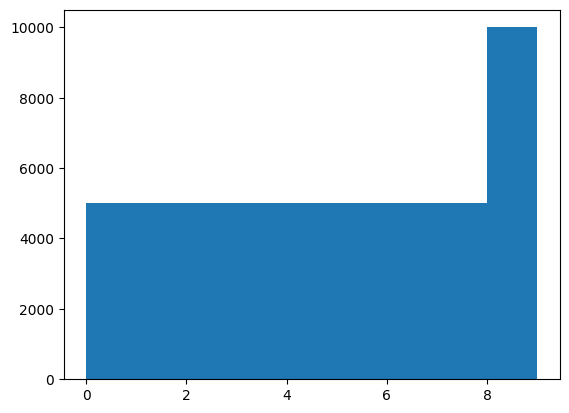

In [74]:
_ = plt.hist(targets_train.numpy(), bins="auto")
plt.show()

In [75]:
dataset_test = []
labels_test = []
targets_test = []

In [76]:
for folder in os.listdir(raw_data_test):
    print(folder)
    for image in os.listdir(os.path.join(raw_data_test, folder)):
        if folder not in labels_test:
            labels_test.append(folder)
        targets_test.append(labels_test.index(folder))
        img_arr = imageio.imread( os.path.join(raw_data_test, folder, image), pilmode="RGB")
        img = torch.from_numpy(img_arr).permute(2, 0, 1).float()
        img /= 255
        dataset_test.append(img)

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


In [77]:
data_test = torch.stack(dataset_test)
targets_test = torch.Tensor(targets_test).type(torch.LongTensor)
torch.save((data_test, targets_test, labels_test), "CIFAR10_data_test")

In [78]:
data_test.shape

torch.Size([10000, 3, 32, 32])

In [79]:
targets_test.shape

torch.Size([10000])

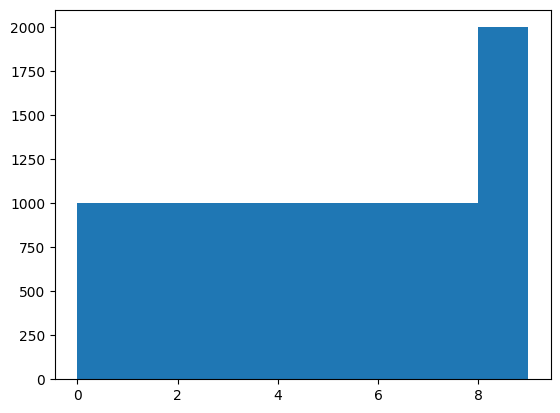

In [80]:
_ = plt.hist( targets_test.numpy() , bins="auto" )
plt.show()

In [81]:
X_train = data_train
y_train = targets_train

In [82]:
X_test = data_test
y_test = targets_test

In [83]:
X_train.shape[0]

50000

In [84]:
y_train[30000].item()

6

In [85]:
X_train[78]

tensor([[[0.4784, 0.4784, 0.4863,  ..., 0.4863, 0.4863, 0.4863],
         [0.4941, 0.4941, 0.5059,  ..., 0.4784, 0.4784, 0.4784],
         [0.5255, 0.5255, 0.5333,  ..., 0.4824, 0.4824, 0.4824],
         ...,
         [0.8078, 0.8078, 0.8000,  ..., 0.5294, 0.4510, 0.3765],
         [0.6941, 0.6627, 0.6431,  ..., 0.5882, 0.5216, 0.3843],
         [0.5843, 0.5529, 0.5529,  ..., 0.4078, 0.4196, 0.4706]],

        [[0.8196, 0.8196, 0.8118,  ..., 0.7961, 0.7961, 0.7961],
         [0.8275, 0.8314, 0.8235,  ..., 0.7882, 0.7882, 0.7882],
         [0.8471, 0.8471, 0.8392,  ..., 0.7922, 0.7922, 0.7922],
         ...,
         [0.8392, 0.8471, 0.8471,  ..., 0.6039, 0.5255, 0.4549],
         [0.7451, 0.7137, 0.7020,  ..., 0.6353, 0.5686, 0.4353],
         [0.6392, 0.6078, 0.6196,  ..., 0.4471, 0.4588, 0.5098]],

        [[0.9373, 0.9373, 0.9294,  ..., 0.9176, 0.9176, 0.9176],
         [0.9412, 0.9373, 0.9373,  ..., 0.9098, 0.9098, 0.9098],
         [0.9412, 0.9333, 0.9294,  ..., 0.9137, 0.9137, 0.

In [86]:
CIFAR_train_list = [(X_train[i], y_train[i].item()) for i in range(X_train.shape[0])]

In [87]:
CIFAR_test_list = [(X_test[i], y_test[i].item()) for i in range(X_test.shape[0])]

In [88]:
batch_size = 16

In [89]:
train_dl = torch.utils.data.DataLoader(CIFAR_train_list, batch_size=batch_size, shuffle=True)

In [90]:
test_dl = torch.utils.data.DataLoader(CIFAR_test_list, batch_size=10000, shuffle=True)

In [91]:
class MLP_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear( 32*32*3 ,20)
        self.act1    = nn.Sigmoid()
        self.linear2 = nn.Linear(20 , 10)
        self.act2    = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        y_pred = self.act2(x)
        return y_pred

In [92]:
def training_loop( N_Epochs, model, loss_fn, opt ):
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            xb = xb.view((16, -1))
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
        if epoch % 5 == 0:
            print(epoch, "loss=", loss)

In [93]:
N_Epochs = 500
learning_rate = 0.001

In [94]:
model = MLP_net()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [95]:
training_loop(N_Epochs, model, loss_fn, opt)

0 loss= tensor(2.2429, grad_fn=<NllLossBackward0>)
5 loss= tensor(1.9965, grad_fn=<NllLossBackward0>)
10 loss= tensor(2.1425, grad_fn=<NllLossBackward0>)
15 loss= tensor(1.9137, grad_fn=<NllLossBackward0>)
20 loss= tensor(2.0692, grad_fn=<NllLossBackward0>)
25 loss= tensor(1.9504, grad_fn=<NllLossBackward0>)
30 loss= tensor(1.9719, grad_fn=<NllLossBackward0>)
35 loss= tensor(2.0401, grad_fn=<NllLossBackward0>)
40 loss= tensor(2.1109, grad_fn=<NllLossBackward0>)
45 loss= tensor(1.8464, grad_fn=<NllLossBackward0>)
50 loss= tensor(1.9516, grad_fn=<NllLossBackward0>)
55 loss= tensor(2.0901, grad_fn=<NllLossBackward0>)
60 loss= tensor(2.0213, grad_fn=<NllLossBackward0>)
65 loss= tensor(2.1084, grad_fn=<NllLossBackward0>)
70 loss= tensor(2.0228, grad_fn=<NllLossBackward0>)
75 loss= tensor(1.9320, grad_fn=<NllLossBackward0>)
80 loss= tensor(2.0840, grad_fn=<NllLossBackward0>)
85 loss= tensor(2.2907, grad_fn=<NllLossBackward0>)
90 loss= tensor(2.1482, grad_fn=<NllLossBackward0>)
95 loss= tenso

In [96]:
def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))

In [97]:
with torch.no_grad():
    for x_real, y_real in test_dl:
        batch_size = x_real.shape[0]
        x_real = x_real.view((batch_size, -1))
        y_pred = model(x_real)
        vals, indeces = torch.max(y_pred, dim=1)
        preds = indeces
        print_metrics_function(y_real, preds)

Accuracy: 0.41
Confusion Matrix:
[[508  40  32  56  12  22  24  63 162  81]
 [ 49 483  16  83   8  50  32  51  70 158]
 [130  42 202 131 126  91 121  89  47  21]
 [ 51  54  58 333  36 187 136  68  37  40]
 [ 77  15 114  82 311  83 143 129  26  20]
 [ 35  34  68 233  57 328  95  88  42  20]
 [ 13  21  76 153  98  78 485  47  15  14]
 [ 42  36  56 102  57  86  60 455  28  78]
 [119  70  12  51   3  50  14  26 568  87]
 [ 55 155   7  57   8  37  52  67 102 460]]
Precision: 0.414
Recall: 0.413
F1-measure: 0.410
